# 1. INTRODUÇÃO

O uso de satélites em órbita da Lua vem se tornando cada vez mais comum com o objetivo de conhecer melhor o ambiente afim para permitir o planejamento mais eficiente de missões de pouso e construção de infraestrutura de suporte a presença humana permanente na superficie. Entretanto, o nosso satélite natural sofre de diversas anomalias gravitacionais devido a variação na concentração de massa (*mascons*) sob sua superficie. E, essas anomalias são de magnitude suficiente para causar perturbações e fazer com que uma órbita lunar mude significativamente ao longo dos dias. Principalmente se tratatando de uma `Órbita Lunar Baixa (LLO)` abaixo de 100km.

Essas perturbações são classificadas como sendo de curto período ou menor que o perído orbital. Ou seja, não seguem uma característica linear e podem ser causadas também por outros fatores como atração gravitacional de um terceiro corpo (ex: Terra e Sol), pressão da radiação solar ou até mesmo pelos sistemas de controle de atitude e trajetória do próprio satélite.

Esse tipo de problema gerado por essas perturbações é conhecido com `ERRO DE DERIVA (ou DRIFT em inglês)` refere-se a uma situação em que um dispositivo ou sistema de medição apresenta uma diferença ou desvio gradual em relação a um valor de referência esperado ao longo do tempo. Esse desvio pode ocorrer devido às perturbações e também ao envelhecimento, desgaste, instabilidade ou calibração inadequada do equipamento. Nas figuras 1a e 1b, podemos ver o desvio provocado por uma anomalia simulada em um satélite orbitando a 50km de altitude.

<img src="https://docs.google.com/uc?export=download&id=1NAN6aAkShDnVl1L84q1ddA8hfw3PG58l" width="600"/>

`Figura 1a`: Trajetória diferente da esperada para uma órbita elíptica devido a perturbação.

<img src="https://docs.google.com/uc?export=download&id=1KEc56I3Hbtn8TwKjg5q7wBuz7z5EV2Cj" width="600"/>

`Figura 1b`: Inclinação da órbita alterada em relação ao equador devido a perturbação.

Na situação apresentada, torna-se impossível converter as medições dos sensores inercias para a localização do satélite em um sistema de coordenadas geodésicas (latitude e longitude). Também não possível determinar sua altitude para prevenir escape ou queda da órbita.

Esse problema também ocorre em menor escala e menor frenquência com satélites em órbita da terra. Porém, estimar o erro se torna mais fácil por meio de pontos de controle visuais ou estações terrestres de monitoramento. Recursos indisponíveis no caso da Órbita Lunar.

Existem estudos que trabalham Modelos de Visão Computacional baseados em `Visual SLAM (Simultaneous Localization And Mapping)` que podem ser utilizados para determinação da posição e altitude. Porém possuem um grau de imprecisão maior em baixa altitude e requerem maior poder computacional para estimativa de erro em tempo real.

Este trabalho propõe explorar um uso de dados de trajetória de diversas órbitas e perturbações inseridas em momentos aleatórios para determinar se é possível construir um estimador de erro baseado em aprendizado de máquina sem a necessidade do uso de imagens.

# 2. BASE DE DADOS

A base de dados utilizada neste experimento que foi gerada em um simulador 3D do sistema `Satélite-Lua-Terra-Sol` com objetivo de reproduzir o movimento completo do satélite ao longo do ano solar acompanhando a Lua e a Terra em volta do Sol gerando, inclusive, as imagens correspondentes ao apontamento de uma câmera simulada para a superfice lunar de modo a pertimir o uso das imagens como contra-prova do posicionamento geodésico esperado em cada captura do movimento.

## Download dos Arquivos

In [1]:
!rm -rf samples
!rm -rf samples*.zip

In [2]:
%%capture

!gdown 1YApe0RI15DyPd9RVRFhL0lijbi3cipqx
!unzip Moon-Estimator-Samples12.zip

## Montagem dos Dataframes

Após o download dos arquivos e sua descompactação, obtemos os dados em formato JSON, necessitando assim de um tratamento para convertê-los em formato Pandas.DataFrame.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

files = glob.glob("samples/metadata/*.json")

all_data = []

for json_file in files:
    with open(json_file, 'r') as f:
        data = json.load(f)

    data["id_image"] = json_file[17:][:-5]

    all_data.append(data)

df = pd.DataFrame(all_data)

dict_columns = ["id_image", "inclination", "eccentricity", "epoch", "latitude", "longitude", "altitude", "speed", "drift"]
df = pd.DataFrame(all_data, columns=dict_columns)

## Amostra dos Dados

Na tabela a seguir, podemos ver uma amostra dos dados gerados pelo simulador destacando a coluna DRIFT que é de valor 1 sempre que a medição correspondente tiver sido gerada durante uma perturbação simulada que gerou o erro de deriva.

In [4]:
df = df[dict_columns]
print("Shape: " + str(df.shape))

Shape: (13702, 9)


Tabela 01 - Amostragem dos dados

In [5]:
df.sample(5)

,id_image,inclination,eccentricity,epoch,latitude,longitude,altitude,speed,drift
5513,e3051ff5-c6cb-482e-8e2d-787f84e3626f,-12.165171,0.437069,0.90481,351.364349,44.744217,893.176636,4479.000977,0
10553,cb34e204-61d7-4e8c-9f4e-7b4cbeaddbb7,18.012276,0.437075,0.09420,353.514435,208.800369,185.535645,5845.533691,1
7455,c787925e-67dc-4377-a21d-a464d5cc3d61,9.105992,0.436746,0.93674,353.364227,226.562622,59.422867,6068.389648,0
12165,47531842-640d-4c7f-8df3-118a21d84304,17.860538,0.437068,0.17296,342.867645,252.888718,326.129120,5539.577148,0
2806,a23bdf6c-2fbe-435f-93a4-7da8ad0af3c6,-6.479842,0.440552,0.38493,7.621929,314.001923,773.098816,4685.105469,1


# 3. ANÁLISE EXPLORATÓRIA

Os dados gerados correspondem a exemplos de variações esperadas ou não (devido a perturbações) de inclinação, excentricidade, latitude, longitude e altitude de uma órbita elíplita que parte de uma orbital inicial perfeitamente circular.

O ano solar foi gerado já de forma normalizada sendo 1 o ano completo da coluna *epoch*.

É sabido que o simulador planejou órbitas (sem considerar as pertubações) para que a inclinação variasse entre -20 e +20 graus em relação ao equador. E que a altiturde variasse de 50km até 900km no ponto mais próximo da trajetória elíptica.

OBS: Não se sabe a princípio se a variação na velocidade contribui para estimar erro de deriva.




Os dados foram separados de forma cronológica em 70% treino e 30% teste

In [6]:
#ordenação cronológica dos eventos
df.sort_values(by=["epoch"], ascending=True).reset_index(drop=True,inplace=True)

df_train = df.iloc[:int(len(df)*0.7),:]
df_test = df.iloc[int(len(df)*0.7):,:]
print(f"Dimensões do dataset de treino: {df_train.shape}")
print(f"Dimensões do dataset de teste: {df_test.shape}")

Dimensões do dataset de treino: (9591, 9)
Dimensões do dataset de teste: (4111, 9)


## Atributos

Tabela 02 - Objetos

In [7]:
X = df.drop(columns=['id_image', 'drift'])
X.head()

,inclination,eccentricity,epoch,latitude,longitude,altitude,speed
0,12.868405,0.437235,0.92087,12.844708,86.296707,867.570251,4901.367676
1,1.345832,0.440495,0.67016,358.704346,285.902557,487.143341,5213.380859
2,-12.629778,0.437689,0.79619,349.521515,124.277512,108.503845,5950.020996
3,-1.598301,0.440519,0.85672,358.901947,43.348907,881.184204,4499.226074
4,-1.809198,0.440168,0.08923,359.918060,177.415497,602.035034,5445.920410


In [8]:
print("Shape: "+ str(X.shape))

Shape: (13702, 7)


## Target

Tabela 03 - Ocorrência de Drift

In [9]:
y = df["drift"].copy()
y.value_counts()

,count
drift,
0,9908
1,3794


## Caracterização

Todos os atributos de entrada são do tipo Quantitativo Contínuo. Já o atributo de saída é do tipo Qualitativo, pois indica se houve ou não a ação de drift.

In [10]:
X.dtypes

,0
inclination,float64
eccentricity,float64
epoch,float64
latitude,float64
longitude,float64
altitude,float64
speed,float64


## Quantitativos Intervalares

Foi classificado como intervalar pois representa a progressão do tempo ao longo do ano. Possue uma escala e uma ordem

In [11]:
#print('epoch', X.epoch.diff().mean())
X["epoch"].sort_values().head()

,epoch
8310,0.00009
906,0.00014
12316,0.00019
3861,0.00025
6503,0.00030


## Quantitativos Racionais

Ao obersar os limites das variações, vemos que a inclinação ultrapassa os valores -20 e +20 esperados.

In [12]:
print('inclination', X.inclination.min(), X.inclination.max())
print('eccentricity', X.eccentricity.min(), X.eccentricity.max())
print('latitude', X.latitude.min(), X.latitude.max())
print('longitude', X.longitude.min(), X.longitude.max())
print('altitude', X.altitude.min(), X.altitude.max())
print('speed', X.speed.min(), X.speed.max())

inclination -25.572641372680664 25.42613410949707
eccentricity 0.0 0.44060713052749634
latitude -0.0035653586965054274 359.99407958984375
longitude 0.0 358.9178771972656
altitude 50.002769470214844 899.9984130859375
speed 4368.84716796875 6596.79443359375


## Localidade

Foi escolhido o atributo INCLINATION por ter apresentado uma variação fora do intervalo esperado de acordo com o plano de órbitas do simulador. Indicando que esta medida provavelmente foi afetada por distúbios.

In [13]:
print("Média: " + str(X.inclination.mean()))

Média: -0.3206096241971658


In [14]:
print("Mediana: " + str(X.inclination.median()))

Mediana: -0.19212597608566284


In [15]:
print("Primeiro Quartil: "+str(X.inclination.quantile(q=0.25)))
print("Terceiro Quartil: "+str(X.inclination.quantile(q=0.75)))

Primeiro Quartil: -11.126360893249512
Terceiro Quartil: 10.058722496032715


In [16]:
px.violin(X["inclination"],box=True, title='Figura 01 - Boxplot atributo inclinação')

Ao analisar os dados de mediana e quartil em relação a inclinação podemos concluir que existe um leve deslocamento não esperado das órbitas.

Apesar da mediana estar bem próximo de zero esperado, os quartis Q1 e Q3 deveriam ambos estarem próximos de -10 e 10.

Entretanto, nenhum *outlier* foi observado.

## Espalhamento

In [17]:
print("Intervalo: " + str(X.inclination.max() - X.inclination.min()))

Intervalo: 50.998775482177734


In [18]:
print("Variância: " + str(X.inclination.var()))

Variância: 165.693409273127


In [19]:
print("Desvio Padrão: " + str(X.inclination.std()))

Desvio Padrão: 12.87219520024176


## Distribuição

 Obliquidade próxima de zero indica uma distribuição simétrica dos dados

In [20]:
print("Obliquidade: "+ str(X.inclination.skew()))

Obliquidade: 0.012293162704626341


Curtose negativa indica um achatamento na distribuição dos dados

In [21]:
print("Curtose: "+str(X.inclination.kurtosis()))

Curtose: -1.0755625275782434


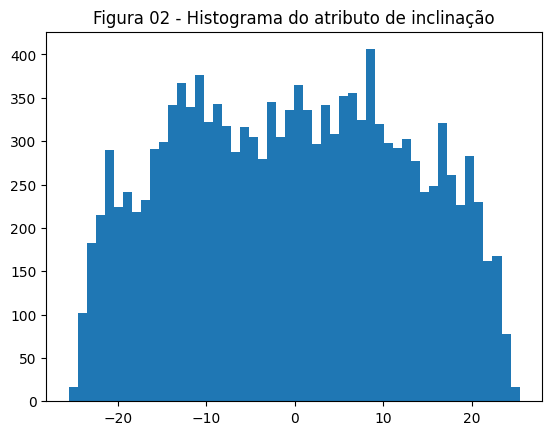

In [22]:
plt.hist(X.inclination, 50)
plt.title('Figura 02 - Histograma do atributo de inclinação')
plt.show()

A concentração maior de órbitas com inclinação próxima de 0 indica que o simulador não conseguiu executar corretamente o plano esperado. A distribuiçao deveria ser mais uniforme pois a mudança planeja deveria ser de 4 graus a cada 30 dias (ou 8% do ano solar).

Quando ocorre uma pergurbação o sistema do simulador faz a correção da órbita o mais rápido possível para a óribita mais similar àquela esperada. Entretanto, o historgrama mostra que a maioria das vezes ele não conseguiu voltar ao plano orginal de executar as órbitas de forma igual ao longo do ano, executando assim algumas órbitas a mais do que outras devido as correções depois das perturbações.

## Correlação

Tabela 04 - Correlação dos atributos

In [23]:
df["drift"] = [int(x) for x in df["drift"]]
df[dict_columns].drop(columns=['id_image']).corr().style.background_gradient()

,inclination,eccentricity,epoch,latitude,longitude,altitude,speed,drift
inclination,1.000000,-0.003114,0.034222,-0.120692,-0.009485,-0.002105,-0.001446,0.003973
eccentricity,-0.003114,1.000000,0.031815,0.020314,0.009858,0.033517,0.002482,0.019091
epoch,0.034222,0.031815,1.000000,-0.004163,0.013652,-0.013745,-0.001454,-0.003160
latitude,-0.120692,0.020314,-0.004163,1.000000,-0.003967,-0.006914,0.007755,0.000074
longitude,-0.009485,0.009858,0.013652,-0.003967,1.000000,-0.267047,0.293975,-0.133673
altitude,-0.002105,0.033517,-0.013745,-0.006914,-0.267047,1.000000,-0.944320,0.319266
speed,-0.001446,0.002482,-0.001454,0.007755,0.293975,-0.944320,1.000000,-0.292830
drift,0.003973,0.019091,-0.003160,0.000074,-0.133673,0.319266,-0.292830,1.000000


# 4. PRÉ-PROCESSAMENTO

## Dados desbalanceados

Pelo drift ser um evento mais improvável de acontecer, nota-se um desbalanceamento dos dados referentes às amostras sem drift e com drift.

Para contornar esse problema, utilizamos a função SMOTE que gera dados artificiais (oversample) para equilibrar um pouco mais a proporção entre eles.

Calibramos o SMOTE para gerar 30% de dados a mais da diferença entre as classes.

**IMPORTANTE: Dados artificiais gerados apenas para os dados de TREINAMENTO!!**

In [24]:
print("Proporção inicial das classes")
df_train["drift"].value_counts(normalize=True)*100

Proporção inicial das classes


,proportion
drift,
0,72.296945
1,27.703055


In [25]:
from imblearn.over_sampling import SMOTE

list_feat_columns = ["inclination","eccentricity","epoch","latitude","longitude","altitude","speed"]

valores_sem_drift = df_train["drift"].value_counts()[0]
valores_com_drift = df_train["drift"].value_counts()[1]
valores_com_drift_oversample = int((valores_sem_drift-valores_com_drift)*0.3+valores_com_drift)

sm = SMOTE(k_neighbors=3, random_state=42,sampling_strategy={1:valores_com_drift_oversample})
X_train_balanced, y_train_balanced = sm.fit_resample(df_train[list_feat_columns], [bool(x) for x in df_train["drift"]])

print("Proporção final das classes")
pd.Series(y_train_balanced).value_counts(normalize=True)*100

Proporção final das classes


,proportion
False,63.766783
True,36.233217


## Normalização

Pela grande discrepância entre os valores das classes, normalizamos os dados através da função StandardScaler que subtrai do valor original a média de valor da coluna e divide pelo desvio padrão da mesma.

Treinamos um StandardScaler para cada coluna utilizando aprenas os **DADOS DE TREINAMENTO** e depois aplicamos os StandardScalers já treinados para os **DADOS DE TREINAMENTO E TESTE**.


Tabela 05 - Amostra dos dados originais

In [26]:
X_train_balanced.sample(3)

,inclination,eccentricity,epoch,latitude,longitude,altitude,speed
5569,-13.008327,0.437016,0.030740,350.036499,130.485428,86.838943,6001.874512
8440,19.804644,0.437294,0.606880,17.732359,117.288666,853.239197,5038.780273
10775,9.713444,0.437104,0.653664,13.637152,71.216601,786.955226,4747.243272


In [27]:
from sklearn.preprocessing import StandardScaler

dict_scaler = {}
X_train_balanced_norm = X_train_balanced.copy()

# Treina o normalizador com os dados de treino
for feat in list_feat_columns:
  dict_scaler[feat] = StandardScaler().fit(np.array(X_train_balanced_norm[feat]).reshape(-1,1))
  X_train_balanced_norm[feat] = dict_scaler[feat].transform(np.array(X_train_balanced_norm[feat]).reshape(-1,1))

df_test_norm = df_test.copy()
# Aplica o normalizador para os dados de teste
for feat in list_feat_columns:
  df_test_norm[feat] = dict_scaler[feat].transform(np.array(df_test_norm[feat]).reshape(-1,1))


Tabela 06 - Amostra dos dados normalizados

In [28]:
X_train_balanced_norm.sample(3)

,inclination,eccentricity,epoch,latitude,longitude,altitude,speed
4685,-1.240554,-0.083843,-1.791666,0.988181,-0.118647,-1.376299,1.296776
9628,1.572752,-0.049421,0.208566,-1.031166,0.137403,0.901617,-0.102740
7220,-0.823310,-0.087665,1.467782,-1.011749,0.720192,-1.595030,1.452005


# 5. RESULTADOS E DISCUSSÕES

Preparamos um pipeline de modelos a serem testados para estudarmos seus comportamentos com os dados.

Por se tratar de um problema de classificação binária, os modelos testados foram:
* Xgboost Classifier
* Logistic Regression
* Naive Bayes
* Support Vector Machine

Como métrica de performance, utilizamos auc (área sob a curva ROC) e realizamos os testes com KFold dividindo os **dados de treino** em 3 partições.

Também utilizamos o GridSearch para teste de alguns hiperparâmetros dos modelos.

In [29]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error as mae
from sklearn.metrics import f1_score, auc

from sklearn.model_selection import cross_val_score

In [30]:
scorer = make_scorer(auc, greater_is_better=True, response_method='predict_proba')

cv = KFold(n_splits=3, shuffle=True, random_state=42)

algorithms = {
    'xgb':  GridSearchCV(
        Pipeline([
            ('xgb', xgb.XGBClassifier(verbosity=0, seed=42))]),
        param_grid={
            'xgb__scale_pos_weight': [1, 100],
        },
        scoring=scorer,
        cv=cv),
    'LR':  GridSearchCV(
        Pipeline([
            ('LR', LogisticRegression(random_state=42))]),
        param_grid={
            'LR__penalty': ["l2"] # Changed from ["l1", "l2", "elasticnet"]
        },
        scoring=scorer,
        cv=cv),
    "NB":  GridSearchCV(
        Pipeline([
            ('NB', GaussianNB())]),
        param_grid={
            'NB__var_smoothing': [1e-11, 1e-10, 1e-9]
        },
        scoring=scorer,
        cv=cv),
    "svm":  GridSearchCV(
        Pipeline([
            ('svm',  svm.SVC(decision_function_shape='ovo'))]),
        param_grid={
            'svm__kernel': ["rbf","linear"]
        },
        scoring=scorer,
        cv=cv)
    }

In [31]:
result = {}
for alg, clf in algorithms.items():
  result[alg] = cross_val_score(clf, X_train_balanced_norm, y_train_balanced, cv=cv, scoring=scorer)

result = pd.DataFrame.from_dict(result)

result

,xgb,LR,NB,svm
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN


Pelo gráfico, nota-se que o NB foi o modelo com menor variância, porém o XGboost foi o que melhor performou com uma grande vantagem para os demais, sendo ele então selecionado como modelo para o estudo.

In [32]:
fig = px.box(result, y=result.columns)
fig.update_layout(title='Figura 03 - Variância dos modelos propostos')
fig.show()

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=No

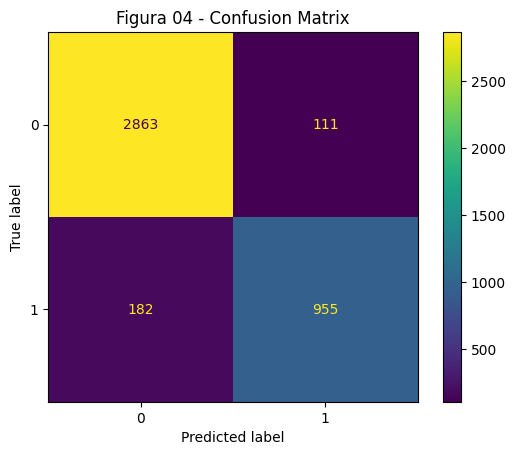

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Melhor xgb selecionado
classifier = algorithms['xgb']
classifier.fit(X_train_balanced_norm, y_train_balanced)
print(classifier.best_estimator_)


y_true = [bool(x) for x in df_test["drift"]]

y_pred = classifier.predict(df_test_norm[list_feat_columns])
y_pred = [bool(x) for x in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)
disp.plot()
plt.title('Figura 04 - Confusion Matrix')
plt.show()

In [34]:
# Tp/(Tp+Fp)
Precision = cm[1][1]/(cm[1][1]+cm[0][1])

# Tp/(Tp+Fn)
Recall = cm[1][1]/(cm[1][1]+cm[1][0])

print(f"Precision = {round(Precision,2)}")
print(f"Recall = {round(Recall,2)}")

Precision = 0.9
Recall = 0.84


Com o XGBoost selecionado junto com o seu melhor conjunto de hiperparâmetros, o classificador foi treinado com todos os **dados de treino** e foi posto para predizer os **dados de teste** para avaliarmos sua performance.

Precision = 0.67. Significa dizer que 67% das vezes em que o modelo classifica um caso com positivo, ele é realmente positivo.

Recall = 0.95. Significa dizer que o modelo consegue detectar 95% dos casos positivos.

||pred 0|pred 1|
|---|---|---|
|Real 0|2390|606|
|Real 1|59|1056|


In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Plotamos também a curva ROC do modelo para predizer os dados de treino e teste. Nota-se uma performance muito boa dos dados de treino, pois o modelo já foi enviezado por eles durante seu treinamento.

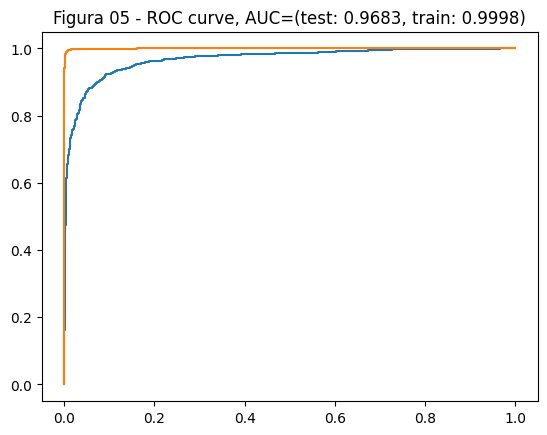

In [36]:
y_pred_proba_train = classifier.predict_proba(X_train_balanced_norm[list_feat_columns])
y_pred_proba_test = classifier.predict_proba(df_test_norm[list_feat_columns])

fpr_test, tpr_test, _ = roc_curve([bool(x) for x in df_test["drift"]], y_pred_proba_test[:, 1])
fpr_train, tpr_train, _ = roc_curve([bool(x) for x in y_train_balanced], y_pred_proba_train[:, 1])

auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)

plt.title(f"Figura 05 - ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.show()

# 6. CONCLUSÕES

* Percebemos que com os dados muito desbalanceados, os modelos tem uma performance bem ruim, classificando todos os eventos como classe 0. O balanceamento dos dados foi uma parte vital do tratamento de dados.
* Os modelos tiveram performances muito diferentes entre eles no treinamento, evidenciando as diferentes propriedades oriundas das técnicas de cada um deles e a necessidade de testá-los antes de definir um modelo final.
* Métrica mais importante para o trabalho é o recall para evitar que o satélite colida com a lua. O precision é importante, mas não essencial, com ele é possivel evitar gastos de energia desnecessários para corrigir um drift que não aconteceu.
* Pela forma em que o problema foi modelado, não conseguimos prever quando ocorrerá um drift, mas conseguimos identificá-lo após ele acontecer. A situação não é ideal, mas atinge nosso propósito inicial.
* Para um deploy, o modelo seria treinado com a **base total** de dados e seria selecionado um threshold que privilegiasse o recall em detrimento do precision.